# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

<span style="color:red">Nosso projeto girará em torno de prever com a melhor assertividade possível a renda dos clientes com base nas variáveis disponíveis. Faremos uma análise preditiva, então interessa que tenhamos uma base de testes e uma base de treino, de modo que possamos verificar e prevenir o risco de overlifting...</span>


## Etapa 2 Crisp-DM: Entendimento dos dados
<span style="color:red">Nossos dados se resumem a um dataframe com diversas informações a respeito de clientes, a respeito de suas condições de vida (moradia, estado civil, posse de bens)

Estes dados, usaremos para prever a renda dos mesmos, uma previsão que pode ser útil em diversos contextos, principalmente de analise financeira.</span>


### Dicionário de dados

<span style="color:red">Glossário de variáveis:</span>

| **Variável**             | **Descrição**                                                                             | **Tipo**       |
| ------------------------ | ----------------------------------------------------------------------------------------- | -------------: |
| `data_ref`               | A data de referência da coleta dos dados                                                   | OBJECT         |
| `id_cliente`             | Uma identidade numérica do cliente, única                                                  | int            |
| `sexo`                   | Designa o sexo do cliente                                                                  | OBJECT-> bool       |
| `posse_de_veiculo`       | Explicita se o cliente possui ou não automóvel                                             | bool           |
| `posse_de_imovel`        | Explicita se o cliente possui ou não imóvel                                                | bool           |
| `qtd_filhos`             | Designa quantos filhos o cliente tem                                                       | int            |
| `tipo_renda`             | Designa o tipo da fonte de rendimentos do cliente                                          | OBJECT         |
| `educacao`               | Designa o grau de escolaridade do cliente                                                  | OBJECT         |
| `estado_civil`           | Designa o estado civil do cliente                                                          | OBJECT         |
| `tipo_residencia`        | Designa o tipo da residência onde vive o cliente                                           | OBJECT         |
| `idade`                  | Designa a idade do cliente                                                                 | int            |
| `tempo_emprego`          | Designa a quanto tempo o cliente está no mesmo emprego                                     | float          |
| `qt_pessoas_residencia`  | Designa a quantidade de pessoas que compartilham a residência com o cliente                | float → int    |
| `renda`                  | O rendimento mensal do cliente                                                             | float               | ESCREVER AQUI|





C:\Users\Matheus\AppData\Local\Temp\ipykernel_25716\3469175054.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tempo_emprego_group = renda.groupby('cut_tempo_emprego')['renda'].mean().reset_index()


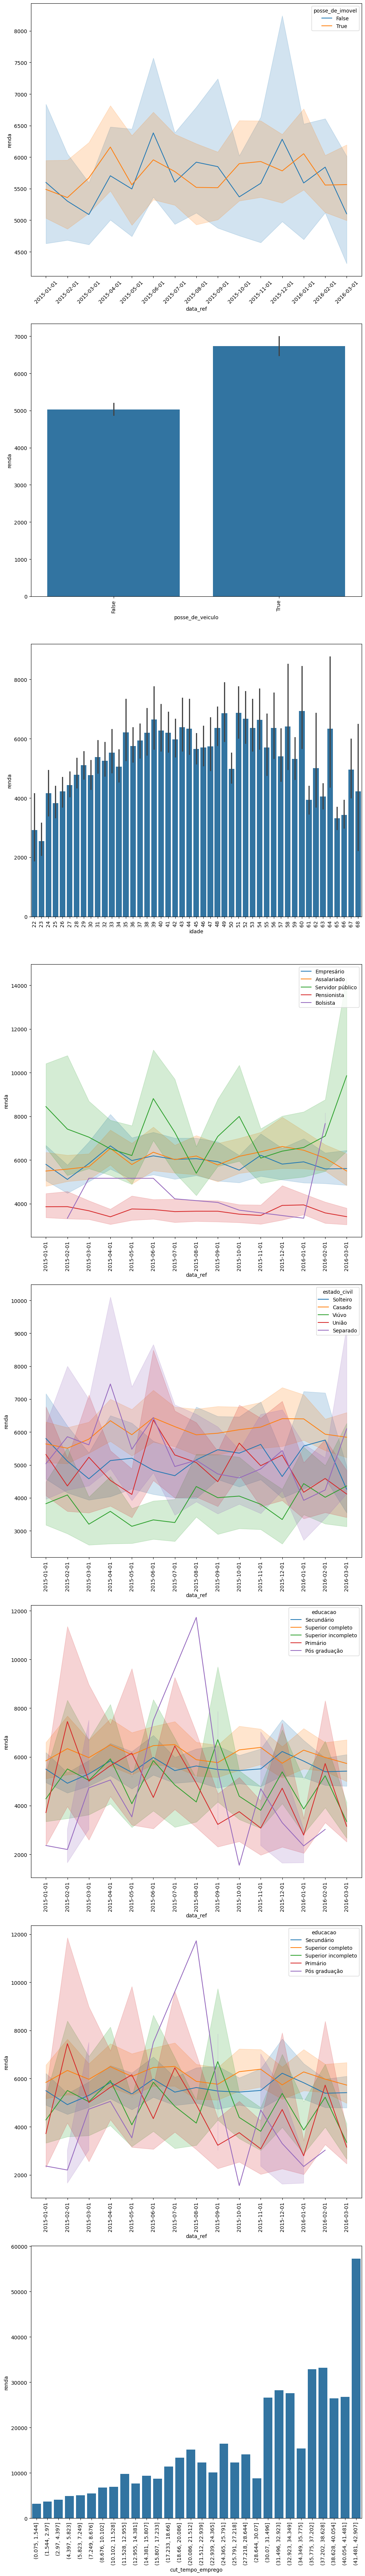

In [10]:
renda = pd.read_csv('previsao_de_renda.csv')

fig, ax = plt.subplots(8,1,figsize=(10,70))
sns.lineplot(x='data_ref',y='renda', hue='posse_de_imovel', data=renda, ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
sns.barplot(x='posse_de_veiculo', y='renda',data=renda, ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)
sns.barplot(x='idade', y='renda', data=renda, ax=ax[2])
ax[2].tick_params(axis='x', rotation=90)
sns.lineplot(x='data_ref', y='renda', hue = 'tipo_renda', data=renda, ax=ax[3])
ax[3].tick_params(axis='x', rotation = 90)
ax[3].legend(loc = 'upper right')
sns.lineplot(x='data_ref', y='renda', hue='estado_civil', data=renda, ax=ax[4])
ax[4].tick_params(axis='x', rotation=90)
sns.lineplot(x='data_ref', y='renda', hue='educacao', data=renda, ax=ax[5])
ax[5].tick_params(axis='x', rotation=90)
sns.lineplot(x='data_ref', y='renda', hue='educacao', data=renda, ax=ax[6])
ax[6].tick_params(axis='x', rotation=90)
renda['cut_tempo_emprego'] = pd.cut(renda['tempo_emprego'], bins=30)
tempo_emprego_group = renda.groupby('cut_tempo_emprego')['renda'].mean().reset_index()
pd.DataFrame(tempo_emprego_group)
sns.barplot(x='cut_tempo_emprego', y='renda', data=tempo_emprego_group, ax=ax[7])
ax[7].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

<span style="color:red">Os pacotes que estaremos utilizando são: Pandas, Seaborn, Scikit-learn, Matplotlib.pyplot, Streamlit</span>


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ks_2samp
import seaborn as sns
from seaborn import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ydata_profiling import ProfileReport
import statsmodels.api as sm
import statsmodels.formula.api as smf


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

ModuleNotFoundError: No module named 'ydata_profiling'

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [27]:
renda = pd.read_csv('previsao_de_renda.csv')

Uma das coisas que mais podemos notar no nosso relatório, é a alta correlação entre diversas variáveis. Para amenizar este problema, combinaremos duas técnicas:
* Uma seleção stepwise
* Uma regressão elastic-net para misturar as regressões ridge e lasso, e assim minimizar os efeitos da multicolinearidade acusada pelo
  alto nível de correlação entre várias variáveis.

### Entendimento dos dados - Bivariadas




<span style="color:red">ESCREVER AQUI</span>


<span style="color:red">Faremos aqui uma análise de algumas variáveis fortemente relacionadas com a renda, utilizando gráficos do SNS</span>


## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



<span style="color:red">ESCREVER AQUI</span>


In [57]:
# Tendo em vista que os missings do tempo de emprego provavelmente dizem respeito à pessoas que não estão empregadas, (portanto não é 
# aplicável "tempo de emprego" para elas, converteremos nossos na em 0)

renda = renda.fillna(value=0)

In [59]:
# Transformando qt_pessoas_residencia em int:
renda['qt_pessoas_residencia'] = renda['qt_pessoas_residencia'].astype(int)

In [60]:
# Retirando colunas que não são pertinentes na análise:
renda = renda.drop(columns= ['data_ref', 'id_cliente', 'Unnamed: 0'], errors='ignore')

In [61]:
# Transformando objects em dummies:
dummie_vars = []
for col in renda.columns:
    if renda[col].dtype == 'object':
        dummie_vars.append(col)
renda = pd.get_dummies(data=renda, columns=dummie_vars, drop_first=True)


In [62]:
# Transformando booleanos em int:
for col in renda.columns:
    if renda[col].dtype == 'bool':
        renda[col] = renda[col].astype(int)


In [63]:
# Retirar os espaços das colunas:
colunas = renda.columns
colunas_renomeadas = [s.replace(' ', '_') for s in colunas]
renda.columns = colunas_renomeadas


In [65]:
# Separando as bases de treino e teste:
X = renda.drop(columns = ['renda'])
Y = pd.DataFrame(renda['renda'])
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=40028922)

# Criando os dataframes de treino e teste
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


<span style="color:red">Agora, rodaremos um algoritmo stepwise para selecionar as variáveis a serem inclusas em nossa regressão elastic net, e depois, iremos usar um join para converter essa lista de variáveis em um modelo pronto para o uso no patsy! Nosso modelo usará o as variáveis explicativas para explicar o log da renda, e depois fazer a conversão. Assim, teremos: </span>

In [68]:
# Selecionando as variáveis com o stepwise:

var_to_regr = stepwise_selection(X_train, Y_train, threshold_in=0.05, threshold_out=0.05)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 6.0023e-262
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 3.1459e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  idade                          with p-value 6.14467e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade']
Add  educacao_Superior_completo     with p-value 4.91919e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo']
Add  posse_de_imovel                with p-value 0.0300379
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'posse_de_imovel']
Add  estado_civil_Solteiro          with p-value 0.0343881
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'posse_de_imovel', 'estado_civil

['tempo_emprego',
 'sexo_M',
 'tipo_renda_Empresário',
 'idade',
 'educacao_Supe_ior completo',
 'posse_de_imovel',
 'estado_civieiro']l_Solt foram as nossas variáveis selecionadas. Portanto, serão as variáveis que usaremos na construção do nosso algoritmo de regressão utilizando Elastieiro']

In [90]:
# Formatando as variávies para uso no patsy:
selected_vars = ' + '.join(var_to_regr)
modelo = 'np.log(renda) ~ ' + selected_vars + '+ posse_de_veiculo'

### Rodando o modelo


<span style="color:red">Vamos optar por utilizar o log da renda para traçar a nossa relação, visto que trás melhores resultados.</span>


In [114]:

model_stepwise = smf.ols(modelo, data=df_train)
regr_stepwise = model_stepwise.fit_regularized(method='elastic_net'
                                              , refit=True
                                              , L1_wt=0.4
                                              , alpha=.1)
regr_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     1018.
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:07:37   Log-Likelihood:                -10241.
No. Observations:                9320   AIC:                         2.049e+04
Df Residuals:                    9315   BIC:                         2.054e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.2631      0.036    203.087      0.000       7.193       7.333
tempo_emprego                  0.0617      0.001     51.962      0.000       0.059       0.064
sexo_M                         0.8029      0.016     50.703      0.000       0.772       0.834
tipo_renda_Empresário          0.1442      0.017      8.591      0.000       0.111       0.177
idade                          0.0049      0.001      5.735      0.000       0.003       0.007
educacao_Superior_completo          0          0        nan        nan           0           0
posse_de_imovel                     0          0        nan        nan           0           0
estado_civil_Solteiro               0          0        nan        nan           0           0
posse_de_veiculo                    0          0        nan        nan           0           0
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.138
Skew:                           0.004   Prob(JB):                        0.933
Kurtosis:                       2.983   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Etapa 5 Crisp-DM: Avaliação dos resultados


<span style="color:red">Obtivemos um R² satisfatório na base de testes, e com relação ao logaritmo da renda... porém, o que nos interessa é nossa capacidade de prever a renda, e não seu logaritmo. Agora, portanto, veremos a adequação do modelo em prever a renda em si, e também verificaremos esta mesma capacidade na base de testes.</span>


In [115]:
log_renda_pred = regr_stepwise.predict(x_test)
renda_pred = np.exp(log_renda_pred)
r2 = metrics.r2_score(y_test, renda_pred)
r2

0.2681675255587592

In [116]:
# Conseguimos obter um R² de .268 na base de testes, o que é um resultado razoável para um dado difícil de se prever como a renda...

# Um comentário: utilizar um parametro L1 menor dentro do elastic_net, nos concederia uma eficiência maior na base de treino, mas
# menor na base de testes, ou seja, um overfiting...

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.